<a href="https://colab.research.google.com/github/DSRaza403/LAB-Tasks/blob/main/Lab%202/Lab2A_Mohammed_Raza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Lab 2(A) - EDA Big Data**

###Name: Mohammed Raza Asfak Chidimar

###Matric no.: MCS231004

# Exploratory Data Analysis of 7+ million company dataset

## Objective

* What can we learn about business names?
* How can we use these insights?

## Imports

In [3]:
pip install geotext

In [2]:
pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geotext
import collections
import string, sys, os, re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import Image
from functools import reduce
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [4]:
warnings.filterwarnings('ignore')

## Helper functions and classes

In [6]:
class DfOverview:
    """
        Give an overview for a given data frame,
        like null persentage for each columns,
        unique value percentage for each columns and more
    """

    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df

    def missing_value(self) -> None:
        nullSum = self.df.isna().sum()
        return [col for col in nullSum]

    def percentage(self, list):
        return [str(round(((value / self.df.shape[0]) * 100), 2)) + '%' for value in list]

    def getOverview(self) -> None:

        _columns = [column for column in self.df]
        _count = self.df.count().values
        _unique = [self.df[column].value_counts().shape[0] for column in self.df]
        _missing_values = self.missing_value()

        columns = [
            'Column',
            'count',
            'missing_value_count',
            'Missing_value_percentage',
            'unique_value_count',
            'unique_value_percentage',
            'dtype']
        data = zip(
            _columns,
            _count,
            _missing_values,
            self.percentage(_missing_values),
            _unique,
            self.percentage(_unique),
            self.df.dtypes
        )
        new_df = pd.DataFrame(data=data, columns=columns)
        return new_df

In [7]:
def show_cols_mixed_dtypes(df):
    mixed_dtypes = {'Column': [], 'Data type': []}
    for col in df.columns:
        dtype = pd.api.types.infer_dtype(df[col])
        if dtype.startswith("mixed"):
            mixed_dtypes['Column'].append(col)
            mixed_dtypes['Data type'].append(dtype)
    if len(mixed_dtypes['Column']) == 0:
        print('None of the columns contain mixed types.')
    else:
        print(pd.DataFrame(mixed_dtypes))

In [8]:
def percent_missing_values(df):

    # Calculate total number of cells in dataframe
    totalCells = np.product(df.shape)

    # Count number of missing values per column
    missingCount = df.isnull().sum()

    # Calculate total number of missing values
    totalMissing = missingCount.sum()

    # Calculate percentage of missing values
    print("The dataset contains", round(((totalMissing/totalCells) * 100), 2), "%", "missing values.")

In [9]:
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * mis_val / len(df)

    # dtype of missing values
    mis_val_dtype = df.dtypes

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_dtype], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'Dtype'})

    # Sort the table by percentage of missing descending and remove columns with no missing values
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,0] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    if mis_val_table_ren_columns.shape[0] == 0:
        return

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [10]:
def convert_to_string(df, columns):
    for col in columns:
        df[col] = df[col].astype("string")

In [11]:
def drop_duplicates(df):
    old = df.shape[0]
    df.drop_duplicates(inplace=True)
    new = df.shape[0]
    count = old - new
    if (count == 0):
        print("No duplicate rows were found.")
    else:
        print(f"{count} duplicate rows were found and removed.")

def plot_dist(df:pd.DataFrame, column:str, color:str='cornflowerblue')->None:
    sns.displot(data=df, x=column, color=color,  kde=False, height=6, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

def plotly_plot_bar(df, x, y, title=None, width=800, color=['cornflowerblue']):
    if title == None:
        title=f'Distribution of {x}'
    fig = px.bar(df, x=x, y=y, title=title)
    return Image(pio.to_image(fig, format='png', width=width))

def plotly_plot_pie(df, column, title=None, width=800, limit=None):
    a = pd.DataFrame({'count': df.groupby([column]).size()}).reset_index()
    a = a.sort_values("count", ascending=False)
    if limit:
        a.loc[a['count'] < limit, column] = f'Other {column}s'
    if title == None:
        title=f'Distribution of {column}'
    fig = px.pie(a, values='count', names=column, title=title)
    return Image(pio.to_image(fig, format='png', width=width))

## Data Reading

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
! pip install kaggle
! mkdir ~/.kaggle

In [14]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [15]:
! kaggle datasets download -d peopledatalabssf/free-7-million-company-dataset
! unzip free-7-million-company-dataset

 95% 265M/278M [00:04<00:00, 82.2MB/s]
100% 278M/278M [00:04<00:00, 65.1MB/s]
Archive:  free-7-million-company-dataset.zip
  inflating: companies_sorted.csv    


In [16]:
# reading the companies_sorted csv file
df = pd.read_csv("/content/companies_sorted.csv")
df

,Unnamed: 0,name,domain,year founded,industry,size range,locality,country,linkedin url,current employee estimate,total employee estimate
0,5872184,ibm,ibm.com,1911.0,information technology and services,10001+,"new york, new york, united states",united states,linkedin.com/company/ibm,274047,716906
1,4425416,tata consultancy services,tcs.com,1968.0,information technology and services,10001+,"bombay, maharashtra, india",india,linkedin.com/company/tata-consultancy-services,190771,341369
2,21074,accenture,accenture.com,1989.0,information technology and services,10001+,"dublin, dublin, ireland",ireland,linkedin.com/company/accenture,190689,455768
3,2309813,us army,goarmy.com,1800.0,military,10001+,"alexandria, virginia, united states",united states,linkedin.com/company/us-army,162163,445958
4,1558607,ey,ey.com,1989.0,accounting,10001+,"london, greater london, united kingdom",united kingdom,linkedin.com/company/ernstandyoung,158363,428960
...,...,...,...,...,...,...,...,...,...,...,...
7173421,1494427,certiport vouchers,certiportvouchers.com,2011.0,information technology and services,1 - 10,NaN,NaN,linkedin.com/company/certiport-vouchers,0,1
7173422,1494429,black tiger fight club,blacktigerclub.com,2006.0,"health, wellness and fitness",1 - 10,"peking, beijing, china",china,linkedin.com/company/black-tiger-club-hero,0,6
7173423,4768462,catholic bishop of chicago,NaN,NaN,religious institutions,1 - 10,"inverness, illinois, united states",united states,linkedin.com/company/catholic-bishop-of-chicago,0,1
7173424,1494436,medexo robotics ltd,NaN,NaN,research,1 - 10,"london, london, united kingdom",united kingdom,linkedin.com/company/medexo-robotics-ltd,0,2


## General Statistics

In [17]:
# number of elements(cells) in the df
df.size

78907686

In [18]:
# rows and columns in the df
df.shape

(7173426, 11)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7173426 entries, 0 to 7173425
Data columns (total 11 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Unnamed: 0                 int64  
 1   name                       object 
 2   domain                     object 
 3   year founded               float64
 4   industry                   object 
 5   size range                 object 
 6   locality                   object 
 7   country                    object 
 8   linkedin url               object 
 9   current employee estimate  int64  
 10  total employee estimate    int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 602.0+ MB


In [20]:
df_overview = DfOverview(df)
df_overview.getOverview()

,Column,count,missing_value_count,Missing_value_percentage,unique_value_count,unique_value_percentage,dtype
0,Unnamed: 0,7173426,0,0.0%,7173426,100.0%,int64
1,name,7173423,3,0.0%,7004634,97.65%,object
2,domain,5522805,1650621,23.01%,5474764,76.32%,object
3,year founded,3566446,3606980,50.28%,234,0.0%,float64
4,industry,6883423,290003,4.04%,148,0.0%,object
5,size range,7173426,0,0.0%,8,0.0%,object
6,locality,4664601,2508825,34.97%,96244,1.34%,object
7,country,4824219,2349207,32.75%,236,0.0%,object
8,linkedin url,7173426,0,0.0%,7173426,100.0%,object
9,current employee estimate,7173426,0,0.0%,5379,0.07%,int64


Here we can see detailed informations of the columns including the amount missing and unique values.

## Dropping unnecessary Columns

The column 'Unamed: 0' most of the times represents the index when we save our dataframe to csv along with our index. In this is the case, since each index is unique and not actually related to each row, removing it is advisable. Let us check its uniqueness.

In [21]:
# comparing the number of unique values of 'Unnamed: 0' and the number of rows
len(df['Unnamed: 0'].unique()) == df.shape[0]

True

Since my assumption is correct, I will remove the column.

In [22]:
df.drop(columns=['Unnamed: 0'], inplace=True)

## Missing Values

In [23]:
percent_missing_values(df)

The dataset contains 14.51 % missing values.


In [24]:
missing_values_table(df)

Your selected dataframe has 10 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values,Dtype
year founded,3606980,50.28,float64
locality,2508825,34.97,object
country,2349207,32.75,object
domain,1650621,23.01,object
industry,290003,4.04,object
name,3,0.00,object


From the missing table we can see that there are 6 columns with missing values. But name and industry are very necessary. So we will remove rows with null values in these columns.

In [25]:
df.drop(df.index[df.name.isna()], inplace=True)
df.drop(df.index[df.industry.isna()], inplace=True)

In [26]:
missing_values_table(df)

Your selected dataframe has 10 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values,Dtype
year founded,3317945,48.20,float64
locality,2304053,33.47,object
country,2148684,31.22,object
domain,1473392,21.40,object


## Data Types

Let's check if there are columns with mixed data types.

In [27]:
show_cols_mixed_dtypes(df)

None of the columns contain mixed types.


In [28]:
df.dtypes

name                          object
domain                        object
year founded                 float64
industry                      object
size range                    object
locality                      object
country                       object
linkedin url                  object
current employee estimate      int64
total employee estimate        int64
dtype: object

In [29]:
df.head()

,name,domain,year founded,industry,size range,locality,country,linkedin url,current employee estimate,total employee estimate
0,ibm,ibm.com,1911.0,information technology and services,10001+,"new york, new york, united states",united states,linkedin.com/company/ibm,274047,716906
1,tata consultancy services,tcs.com,1968.0,information technology and services,10001+,"bombay, maharashtra, india",india,linkedin.com/company/tata-consultancy-services,190771,341369
2,accenture,accenture.com,1989.0,information technology and services,10001+,"dublin, dublin, ireland",ireland,linkedin.com/company/accenture,190689,455768
3,us army,goarmy.com,1800.0,military,10001+,"alexandria, virginia, united states",united states,linkedin.com/company/us-army,162163,445958
4,ey,ey.com,1989.0,accounting,10001+,"london, greater london, united kingdom",united kingdom,linkedin.com/company/ernstandyoung,158363,428960


As we can see from above 'name', 'domain', 'industry', 'size range', 'locality', 'country' and 'linkedin url' hold string values. In addition to this we also know that 'year founded' should hold integer values. Therefore, we will convert these columns to their respective correct data types.

In [30]:
# get the columns with object data type
string_columns = df.select_dtypes(include='object').columns.tolist()
string_columns

['name',
 'domain',
 'industry',
 'size range',
 'locality',
 'country',
 'linkedin url']

In [31]:
convert_to_string(df, string_columns)

In order to convert 'year founded', we have to replace NaN values with 0 so that pandas will not raise an error saying "Cannot convert non-finite values (NA or inf) to integer".

In [32]:
df['year founded'].fillna(0, inplace=True)
df['year founded'] = df['year founded'].astype('int64')

In [33]:
df.dtypes

name                         string
domain                       string
year founded                  int64
industry                     string
size range                   string
locality                     string
country                      string
linkedin url                 string
current employee estimate     int64
total employee estimate       int64
dtype: object

In [34]:
df.head()

,name,domain,year founded,industry,size range,locality,country,linkedin url,current employee estimate,total employee estimate
0,ibm,ibm.com,1911,information technology and services,10001+,"new york, new york, united states",united states,linkedin.com/company/ibm,274047,716906
1,tata consultancy services,tcs.com,1968,information technology and services,10001+,"bombay, maharashtra, india",india,linkedin.com/company/tata-consultancy-services,190771,341369
2,accenture,accenture.com,1989,information technology and services,10001+,"dublin, dublin, ireland",ireland,linkedin.com/company/accenture,190689,455768
3,us army,goarmy.com,1800,military,10001+,"alexandria, virginia, united states",united states,linkedin.com/company/us-army,162163,445958
4,ey,ey.com,1989,accounting,10001+,"london, greater london, united kingdom",united kingdom,linkedin.com/company/ernstandyoung,158363,428960


Now every data type looks good.

## Duplicates

In [35]:
# search for duplicate rows and drop them
drop_duplicates(df)

No duplicate rows were found.


Since name is the feature that uniquely identifies each record(company)record, there should be no duplicates. Let's check that.

In [36]:
df.duplicated(subset=['name']).all()

False

We are safe. No two rows in our dataset contain the same name value.

## Univariate Analysis

Here we will analyze each variable. Let us start by checking the statistics of numeric variables.

In [37]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year founded,6883420.0,1036.865407,1000.340191,0.0,0.0,1952.0,2009.0,2103.0
current employee estimate,6883420.0,14.448108,361.973117,0.0,1.0,1.0,4.0,274047.0
total employee estimate,6883420.0,33.547708,892.356855,1.0,1.0,2.0,8.0,716906.0


Here we can see some wierd results.
* the maximum value for 'year founded' is 2103.
* the minimum value for 'current employee estimate' is 0.

We will check these in detail when we analyze each column.

### Name

In [38]:
# unique value counts
counts_df = df['name'].value_counts().rename_axis('name').reset_index(name='count')
counts_df

,name,count
0,independent consultant,63
1,private practice,53
2,consultant,53
3,independent,49
4,independent contractor,40
...,...,...
6728512,pegasus gold,1
6728513,landmark enterprise group,1
6728514,hotel trail,1
6728515,amplii,1


Even though pandas.DataFrame.duplicated haven't identified any duplicated names, we have discovered there are some using value_counts. Let's investigate these names.

In [39]:
repeated_names = counts_df[counts_df['count'] > 1].name.to_list()

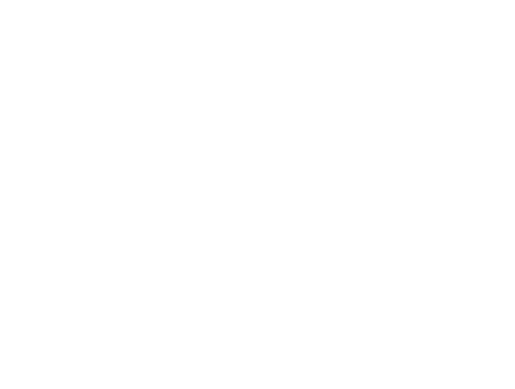

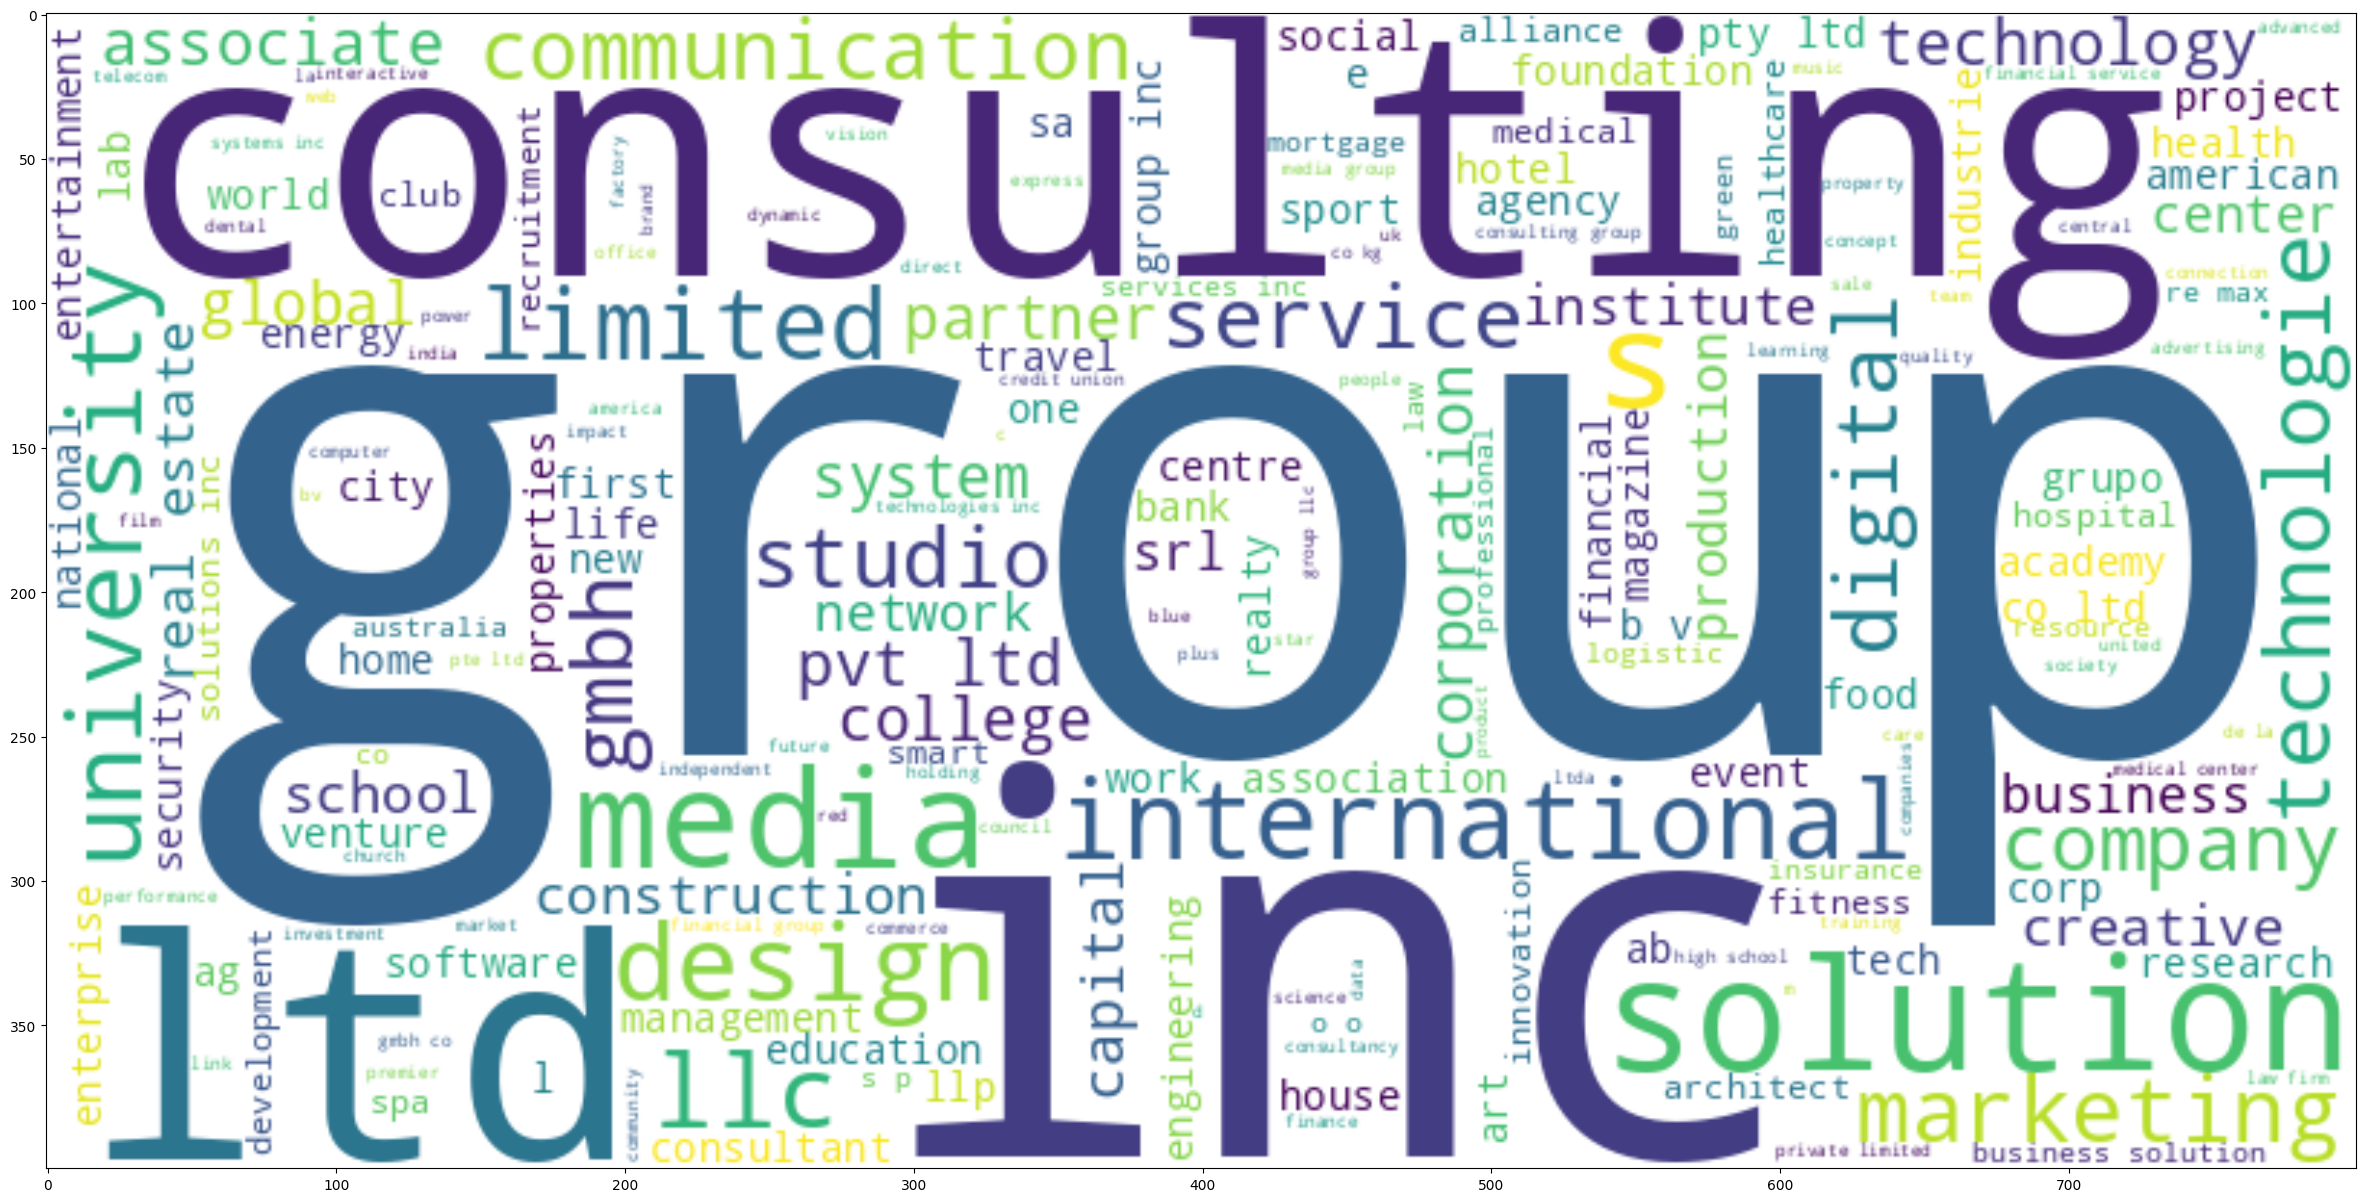

In [40]:
text = " ".join(name for name in df[df.name.isin(repeated_names)].name)

# generate a word cloud image
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

# display the word cloud
plt.axis("off")
plt.figure(figsize=(30,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

The most frequent words in these repeating company names are common words like group, inc, consulting and solution. Having companines with the exact same name in our dataset will conflict with our objective of extracting insights from business names since the values in the other columns differ. So I will remove the companies with their names repeated.

In [41]:
df = df[~df.name.isin(repeated_names)]

Let us examine if there are names containing different kinds of characters other than the english alphabets and space.

In [42]:
# filtering names with a character that is not an english alphabet or space
regexp = re.compile(r'[^a-zA-Z\s]')
df[df.name.apply(lambda x: regexp.search(x)).astype('bool')].name

9                                        at&t
17                       jpmorgan chase & co.
30                     mcdonald's corporation
57           ayatama energi, trisco nusantara
70            secretaría de educación pública
                          ...                
7173397        stone center for yoga & health
7173402                        woonartikel.nl
7173404                     squad sp. z o. o.
7173411    fuller, hadeed, & ros-planas, pllc
7173416                       fit plus s.r.o.
Name: name, Length: 2069320, dtype: string

In [43]:
# filtering names with non-aschii characters, here I considered on the standard aschii characters
regexp = re.compile(r'[^\x00-\x7f]')
df[df.name.apply(lambda x: regexp.search(x)).astype('bool')].name

70                           secretaría de educación pública
81                               verbum traducción y edición
93                                                   l'oréal
168                                   mondelēz international
208                                            itaú unibanco
                                 ...                        
7173288                          uab „plius“ filiāle latvija
7173295           efenex - eficiencia energética extremadura
7173307                                      stora sjöfallet
7173316    versorgungs- und verkehrsgesellschaft saarbrüc...
7173334                iglesia presbiteriana príncipe de paz
Name: name, Length: 286532, dtype: string

In [2]:
# filtering names with digits
regexp = re.compile(r'[0-9]')
df[df.name.apply(lambda x: regexp.search(x)).astype('bool')].name

NameError: name 're' is not defined

As shown above there are a lot of names with digits, punctuations and aplhabets from non-english languages. This is understandable as this dataset conatains companies from different countries. Now let us look for the most comon words in company names.

In [1]:
text = " ".join(name for name in df.name)
print ("There are {} words in the combination of all cells in the column 'name'.".format(len(text)))

# generate a word cloud image
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

# display the word cloud
plt.axis("off")
plt.figure(figsize=(40,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

NameError: name 'df' is not defined

We can conclude the following from the word cloud.
* The most common words are related to company structure like pvt, ltd, limited, llc, co, inc, group, and gmbh.
* Country and industry names are also frequent.
* Even though they are not frequent companies use single characters like s, b and v in their names. I assume that these characters are abbreviations and are mmostly followed by a peried(.).

### Domain

In [ ]:
# unique value counts
counts_df = df['domain'].value_counts().rename_axis('domain').reset_index(name='count')
counts_df

In [ ]:
df[df['domain'] == 'dunked.com']

We can see that there are companies with the same domain but different name. I assume that there was an error while collecting this data or the data was imputed using some criterea. I am saying this because even sister companies have different domains most of the times. Besides this for example companies with the domain 'dunked.com' are from different countries as shown above. This shows that there is low probability of them being sister companies. But since our objective doesn't focus on the domain, we will not drop them.

### Year founded

In [ ]:
# unique value counts
counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='count')
counts_df

As shown above there are some historical companies founded before 1900s. Besides this 0 is the most common value because we have repaced null values with it. Let us examine how many companies were founded before the 20th century.

In [ ]:
df.query("0 < `year founded` < 1900")['year founded'].value_counts().rename_axis('year founded').reset_index(name='count')

It seems that there are some companies founded in the 19th century. What about before the 19th century?

In [ ]:
df.query("0 < `year founded` < 1800")['year founded'].value_counts().rename_axis('year founded').reset_index(name='count')

Earlier we have disovered that the maximum value is 2103. Let us check for vaules bigger than the current year.

In [ ]:
df[df['year founded'] > 2021]

Let us remove these records.

In [ ]:
df.drop(df.index[df['year founded'] > 2021], inplace=True)

Since most companies in the dataset are founded after 1900, let's see their distribution.

In [ ]:
# distribution of companies founded after 1900
plot_dist(df[df['year founded'] > 1900], 'year founded')

### Industry

In [ ]:
# unique value counts
counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='count')
counts_df

The companies in this dataset work in 148 industries. The most common industry is 'infomation technoogy and services'.

In [ ]:
plotly_plot_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='industry', title='Top 10 industries with many companies')

### Size range

In [ ]:
# unique value counts
counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='count')
counts_df

In [ ]:
plotly_plot_pie(df, column='size range', title='Distribution of companies size range', width=800)

More than 93% of the companies have employees less than or equal to 50. I think this shows the reaity since the number of big companies that drive economies around the world is small.

### Locality

In [ ]:
# unique value counts
counts_df = df['locality'].value_counts().rename_axis('locality').reset_index(name='count')
counts_df

Here we can see that most companies are found in the biggest cities of the developed world like london, new york, madrid and paris. Another thing to notice is that london appears both at index 0 and 4 with slight difference. This shows there is an inconsistency. We will extract the cities as a feature later to fix this.

### Country

In [ ]:
# unique value counts
counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='count')
counts_df

Here also as expected most companies are from the developes countries.The top 10 countries with many companies are plotted below.

In [ ]:
plotly_plot_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='country', title='Top 10 countries with many companies')

 Companies from the united states clearly dominate the dataset.

### Linkedin url

In [ ]:
counts_df = df['linkedin url'].value_counts().rename_axis('linkedin url').reset_index(name='count')
counts_df

As shown above each company has its own unique linkedin url. This is because the name of the company, which is unique, is included in each url.

### Current employee estimate

In [ ]:
counts_df = df['current employee estimate'].value_counts().rename_axis('current employee estimate').reset_index(name='count')
counts_df

In [ ]:
plotly_plot_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), x='current employee estimate', y='count', title='Top 10 current employee estimates')

Everything seems fine here except for companies with 0 current employee estimate. I assume the data was not available for this companies so 0 was filled as an indication for missing.

### Total employee estimate

In [ ]:
counts_df = df['total employee estimate'].value_counts().rename_axis('total employee estimate').reset_index(name='count')
counts_df

In [ ]:
plotly_plot_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), x='total employee estimate', y='count', title='Top 10 total employee estimates')

Here 0 is the mode value for total employee estimate. I assume this is also due to missing data.

## Feature Engineering

From the locality column we can extract city which is useful to tackle the inconsistency discussed above in the univariate analysis of locality.

In [ ]:
def extract_city(locality):
    if pd.isnull(locality):
        return '<NA>'
    # extract cities from locality
    geo = geotext.GeoText(locality).cities
    if len(geo) > 0:
        return geo[0]
    return locality.split(',')[0]

df['city'] = df['locality'].apply(extract_city)

From the name we can extract different features like number of characters, words and punctuations. Another feature to be considered is word density. We can also identify if a name contains digits or non-aschii characters.

In [ ]:
df['name_char_count'] = df['name'].apply(lambda name: len(name))

# split name based on comma, space or hyphen
df['name_word_count'] = df['name'].apply(lambda name: len(list(filter(lambda x: x!= '', re.split(r',|\s|-', name)))))

df['name_word_density'] = round(df['name_word_count'] / df['name_char_count'], 2)

punc = string.punctuation
df['name_punc_count'] = df['name'].apply(lambda x : len([a for a in x if a in punc]))

df['name_non_aschii_char_count'] = df['name'].apply(lambda x: len([a for a in x if ord(a) > 127]))

df['name_digit_count'] = df['name'].apply(lambda x: len([a for a in x if a in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']]))

For simplicity and ease of calculating correlation I will categorize the values of 'size range' into number values in an another column.

In [ ]:
def categorize(size):
    switcher={
        '1 - 10': 1,
        '11 - 50': 2,
        '51 - 200': 3,
        '201 - 500': 4,
        '501 - 1000': 5,
        '1001 - 5000': 6,
        '5001 - 10000': 7,
        '10001+': 8
    }
    return switcher.get(size, 0)
df['size_category'] = df['size range'].apply(categorize)

In [ ]:
df.sample(5)

## Correlation Analysis

In [ ]:
df_corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f_fig, f_ax = plt.subplots(figsize=(12, 12))
    f_ax = sns.heatmap(df_corr, mask=mask, vmin=0, vmax=1, square=True,
                        annot=True, annot_kws={"size": 10}, cmap="BuPu")
plt.title('Correlation of numeric features')
plt.show()

As shown above there is no significant correlation between important numeric features. It is no surprise that 'current employee estimate' and 'total employee estimate' are highly correlated as they both describe the size of employees in companies. The same applies to numeric features engineered from the column name. They have correlation because they are derived from the same place. Due to these facts our bivariate analysis will mostly focus on non-numerical features and their interaction with the numerical features.

## Bivariate Analysis

### country and name_char_count

Here we will examine the averege number of characters in company names per countries.

In [ ]:
country_df = df.groupby('country', as_index=False).agg({'name_char_count': 'mean', 'name': 'count'}).rename(columns={'name_char_count': 'mean_name_char', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_char',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_char'] = country_df['mean_name_char'].astype('int16')
country_df

In [ ]:
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))[['name', 'geometry']]
gdf.columns = ['country', 'geometry']
gdf.head()

In [ ]:
# remove antarctica
antarctic_index = int(gdf[gdf['country'] == 'Antarctica'].index.values)
gdf = gdf.drop(gdf.index[antarctic_index])

replace = {
    "United States of America": 'United States',
    "Bosnia and Herz.": 'Bosnia And Herzegovina',
    "Central African Rep.": 'Central African Republic',
    "Côte d'Ivoire": 'Côte D’Ivoire',
    "Dominican Rep.": 'Dominican Republic',
    "Dem. Rep. Congo": 'Democratic Republic Of The Congo',
    "Eq. Guinea": 'Equatorial Guinea',
    "Dominican Rep.": 'Dominican Republic',
    "Solomon Is.": 'Solomon Islands',
    "Trinidad and Tobago": 'Trinidad And Tobago',
    "S. Sudan": 'South Sudan',
}

for (n_old, n_new) in replace.items():
    gdf.country.loc[gdf['country'] == n_old] = n_new

# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_char', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of characters in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

### country and name_word_count

Here we will investigate the averege number of words in company names per countries.

In [ ]:
country_df = df.groupby('country', as_index=False).agg({'name_word_count': 'mean', 'name': 'count'}).rename(columns={'name_word_count': 'mean_name_word', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_word',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_word'] = country_df['mean_name_word'].astype('int16')
country_df

In [ ]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_word', cmap='rainbow', ax=ax, scheme='natural_breaks', k=3, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of words in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

There is high similarity with the map showing averege number of characters in company names by countries. It is obvious as there is a correlation between number of characters and words. Some countries with high average number of characters have medium average number of words. I assume the words used by these countries are longer.

### country and name_punc_count

Now it is time for investigating the averege number of punctuations in company names per countries.

In [ ]:
country_df = df.groupby('country', as_index=False).agg({'name_punc_count': 'mean', 'name': 'count'}).rename(columns={'name_punc_count': 'mean_name_punct_count', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_punct_count',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_punct_count'] = country_df['mean_name_punct_count'].round(2)
country_df

In [ ]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_punct_count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=3, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of punctuations in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

Some countries in europe, the south east asia and south america have company names with a high probability of including a punctuation. Let's see who they are.

In [ ]:
country_df[country_df['mean_name_punct_count'] >= 1]

### country and name_digit_count

Digits are not that much common in company name. But they appear in some names to represent something, for example, the year they were founded. Let's see if there is a relation between country and average number of digits in company names.

In [ ]:
country_df = df.groupby('country', as_index=False).agg({'name_digit_count': 'mean', 'name': 'count'}).rename(columns={'name_digit_count': 'mean_name_digit_count', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_digit_count',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_digit_count'] = country_df['mean_name_digit_count'].round(2)
country_df

The maximum value for average count of digits per country is 0.15 which is very low. This is expected as most company names doesn't include digits.

In [ ]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_digit_count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of digits in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

In [ ]:
country_df[country_df['mean_name_digit_count'] > 0.07]

### country and name_non_aschii_char_count

Company names with non-aschii characters are probably going to be from non-english speaking countries. But the question is which countries have the highest number of average non-aschii characters. Let's find out.

In [ ]:
country_df = df.groupby('country', as_index=False).agg({'name_non_aschii_char_count': 'mean', 'name': 'count'}).rename(columns={'name_non_aschii_char_count': 'mean_name_non_aschii_char_count', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_non_aschii_char_count',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_non_aschii_char_count'] = country_df['mean_name_non_aschii_char_count'].round(2)
country_df

In [ ]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_non_aschii_char_count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of non-aschii characters in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

Let's find out which countries are coded by red.

In [ ]:
country_df[country_df['mean_name_non_aschii_char_count'] >= 0.97]

### country and size range

In [ ]:
country_df = df.groupby('country', as_index=False).agg({'size_category': 'mean', 'name': 'count'}).rename(columns={'size_category': 'mean_size_category', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_size_category',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_size_category'] = country_df['mean_size_category'].round(2)
country_df

In [ ]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_size_category', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege size range category of companies by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

The mean size category ranges from 1.23 to 1.88 in every country with more than or equal to 100 companies in the dataset. This indicates that there are many small companies in these countries which is obvious. That is why the average is lower.

### name and industry

Here we will examine how many and which companies contain words from their respective industries in their names.

In [ ]:
def industry_in_name(row):
    puncs = [punc for punc in string.punctuation]
    puncs.append('and')
    industry_words = set(filter(lambda x: x not in puncs, re.split(r'\s|-', row['industry'])))
    name_words = re.split(r'\s|-', row['name'])
    return len([i for i in name_words if i in industry_words])
df['industry_word_in_name_count'] = df.apply(industry_in_name, axis=1)

In [ ]:
name_industry_df = df[df['industry_word_in_name_count'] > 0]
name_industry_df

Let's explore these companies with respect to their country, size range, industry and year founded.

#### industry_word_in_name_count and country

In [ ]:
country_df = name_industry_df.groupby('country', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
country_df =  country_df.sort_values(by='count',ascending=False).reset_index(drop=True)
country_counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='total_count')
country_df = country_df.merge(country_counts_df, left_on='country', right_on='country', how = 'left')
country_df['country'] = country_df['country'].astype('string').str.title()
country_df

In [ ]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Number of company names containing atleast one word from their industry by country')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

The united states dominates here. But this maybe due to its high number of companies in the dataset as compared to other companies.

#### industry_word_in_name_count and size range

Let us check if these names are related to size range.

In [ ]:
size_df = name_industry_df.groupby('size range', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
size_counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='total_count')
size_df = size_df.merge(size_counts_df, left_on='size range', right_on='size range', how = 'left')
size_df =  size_df.sort_values(by='count',ascending=False).reset_index(drop=True)
size_df

As we can see from the result above, small sized companies tend to have more companies with names conataining atleast a word from their respective industries. This aligns with the general distibution of size range. So I don't think there is a special connection here.

#### industry_word_in_name_count and industry

Let us check if these names are related to which industry.

In [ ]:
industry_df = name_industry_df.groupby('industry', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
industry_counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='total_count')
industry_df = industry_df.merge(industry_counts_df, left_on='industry', right_on='industry', how = 'left')
industry_df =  industry_df.sort_values(by='count',ascending=False).reset_index(drop=True)
industry_df

In [ ]:
industry_df.head(10)

In [ ]:
plotly_plot_bar(industry_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='industry', title='Top 10 industries with atleast one word from their industry in their company names')

The bar chart plotted above shows top 10 industries with words from their respective industry in their company names.

#### industry_word_in_name_count and year founded

In [ ]:
year_df = name_industry_df.groupby('year founded', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
year_df = year_df[year_df['year founded'] != 0]
year_counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='total_count')
year_df = year_df.merge(year_counts_df, left_on='year founded', right_on='year founded', how = 'left')
year_df =  year_df.sort_values(by='count',ascending=False).reset_index(drop=True)
year_df['year founded'] = year_df['year founded'].astype('string')
year_df

In [ ]:
year_df.head(10)

In [ ]:
plotly_plot_bar(year_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='year founded', title='Top 10 years where companies with atleast one word from their industry in their names were founded')

### name and locality

Here we will examine how many and which companies contain words from their respective localities in their names.

In [ ]:
def locality_in_name(row):
    if pd.isnull(row['locality']):
        return np.nan
    puncs = [punc for punc in string.punctuation]
    puncs.append('and')
    locality_words = set(filter(lambda x: x not in puncs, re.split(r'\s|-', row['locality'])))
    name_words = re.split(r'\s|-', row['name'])
    return len([i for i in name_words if i in locality_words])
df['locality_word_in_name_count'] = df.apply(locality_in_name, axis=1)

In [ ]:
name_locality_df = df[df['locality_word_in_name_count'] > 0]
name_locality_df

Let's explore these companies with respect to their country, size range, industry and year founded.

#### locality_word_in_name_count and country

In [ ]:
country_df = name_locality_df.groupby('country', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
country_df =  country_df.sort_values(by='count',ascending=False).reset_index(drop=True)
country_counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='total_count')
country_df = country_df.merge(country_counts_df, left_on='country', right_on='country', how = 'left')
country_df['country'] = country_df['country'].astype('string').str.title()
country_df

In [ ]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Number of company names containing atleast one word from their locality by country')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

#### locality_word_in_name_count and size range

In [ ]:
size_df = name_locality_df.groupby('size range', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
size_counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='total_count')
size_df = size_df.merge(size_counts_df, left_on='size range', right_on='size range', how = 'left')
size_df =  size_df.sort_values(by='count',ascending=False).reset_index(drop=True)
size_df

As we can see from the result above, small sized companies tend to have more companies with names conataining atleast a word from their respective localities. This aligns with the general distibution of size range. So I don't think there is a special connection here.

#### locality_word_in_name_count and industry

In [ ]:
industry_df = name_locality_df.groupby('industry', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
industry_counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='total_count')
industry_df = industry_df.merge(industry_counts_df, left_on='industry', right_on='industry', how = 'left')
industry_df =  industry_df.sort_values(by='count',ascending=False).reset_index(drop=True)
industry_df

In [ ]:
industry_df.head(10)

In [ ]:
plotly_plot_bar(industry_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='industry', title='Top 10 industries with atleast one word from their locality in their company names')

The bar chart plotted above shows top 10 industries with words from their respective locality in their company names.

#### locality_word_in_name_count and year founded

In [ ]:
year_df = name_locality_df.groupby('year founded', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
year_df = year_df[year_df['year founded'] != 0]
year_counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='total_count')
year_df = year_df.merge(year_counts_df, left_on='year founded', right_on='year founded', how = 'left')
year_df =  year_df.sort_values(by='count',ascending=False).reset_index(drop=True)
year_df['year founded'] = year_df['year founded'].astype('string')
year_df

In [ ]:
year_df.head(10)

In [ ]:
plotly_plot_bar(year_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='year founded', title='Top 10 years where companies with atleast one word from their locality in their names were founded')

### name and year founded

Here we will examine how many and which companies contain words from their respective years they were founded in their names.

In [ ]:
def year_in_name(row):
    if (row['year founded'] == 0):
        return None
    year = row['year founded']
    regexp = re.compile(f'{year}')
    return regexp.search(row['name'])

df['year_in_name'] = df.apply(year_in_name, axis=1).astype('bool').astype('int16')

In [ ]:
name_year_df = df[df['year_in_name'] > 0]
name_year_df

Let's explore these companies with respect to their country, size range, industry and year founded.

#### year_in_name and country

In [ ]:
country_df = name_year_df.groupby('country', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
country_df =  country_df.sort_values(by='count',ascending=False).reset_index(drop=True)
country_counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='total_count')
country_df = country_df.merge(country_counts_df, left_on='country', right_on='country', how = 'left')
country_df['country'] = country_df['country'].astype('string').str.title()
country_df

In [ ]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Number of company names containing the year they were founded by country')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

#### year_in_name and size range

Let us check if these names are related to size range.

In [ ]:
size_df = name_year_df.groupby('size range', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
size_counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='total_count')
size_df = size_df.merge(size_counts_df, left_on='size range', right_on='size range', how = 'left')
size_df =  size_df.sort_values(by='count',ascending=False).reset_index(drop=True)
size_df

As we can see from the result above, if a company's name contains the year it was founded the company tends to have a small number of employees. Again this also aligns with the general distibution of size range. So I don't think there is a special connection here.

#### year_in_name and industry

Let us check if these names are related to which industry.

In [ ]:
industry_df = name_year_df.groupby('industry', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
industry_counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='total_count')
industry_df = industry_df.merge(industry_counts_df, left_on='industry', right_on='industry', how = 'left')
industry_df =  industry_df.sort_values(by='count',ascending=False).reset_index(drop=True)
industry_df

In [ ]:
industry_df.head(10)

In [ ]:
plotly_plot_bar(industry_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='industry', title='Top 10 industries with year founded in their companiy names')

The bar chart plotted above shows top 10 industries with year founded in their companiy names. I think that it is obvious that sport companies are very associated with the year they were founded. The table above also proves this. Even though the sports industry has smaller number of companies in the dataset when compared to with the other industries ranking from 2-10, it is ranked as number 1 in the number of companiy names containing the year they were founded.

#### year_in_name and year founded

In [ ]:
year_df = name_year_df.groupby('year founded', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
year_counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='total_count')
year_df = year_df.merge(year_counts_df, left_on='year founded', right_on='year founded', how = 'left')
year_df =  year_df.sort_values(by='count',ascending=False).reset_index(drop=True)
year_df['year founded'] = year_df['year founded'].astype('string')
year_df

In [ ]:
year_df.head(10)

In [ ]:
plotly_plot_bar(year_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='year founded', title='Top 10 years where companies with year founded in their names were founded')

Even though the number of companies founded in 2000 in the dataset are relatively smaller, it is ranked as number 1 in the number of company names containing the year they were founded. I think this is because the year 2000 is special as it is the start of a millenium, a year that comes once in a thousand years.

## Filtering Data and Answering Business Questions

### How many and which company names contain stop words?

In [ ]:
def stopword_in_name(name):
    # split words in name and replace the & symbol with 'and'
    name_words = re.split(r'\s|-',re.sub('&', ' and ', name))
    return len([i for i in name_words if i in STOPWORDS])
df['stopword_in_name_count'] = df['name'].apply(stopword_in_name)

In [ ]:
stopword_df = df[df['stopword_in_name_count'] > 0]
stopword_df

There are more than 930,000 companies whose names contain atleast one stop word.

### How many and which company names contain punctuations?

In [ ]:
punc_df = df[df['name_punc_count'] > 0]
punc_df

There are more than 1,700,000 companies whose names contain atleast one punctuation mark.

### Which words are the most common in company names of each industry?

In [ ]:
industries = list(df['industry'].unique())
industry_name_words_dict = {}
for industry in industries:
    industry_df = df[df['industry'] == f'{industry}']
    text = " ".join(name for name in industry_df.name)
    word_list = list(filter(lambda x: x!= '', re.split(r'\s|-', text)))
    common_words = [pair[0] for pair in collections.Counter(word_list).most_common(50)]
    industry_name_words_dict[f'{industry}'] = common_words

In [ ]:
def append_list(a,b):
    return a + b
all_words = reduce(append_list, list(industry_name_words_dict.values()))

In [ ]:
# select common words found in atleast 20 industries
common_words = [pair[0] for pair in dict(collections.Counter(all_words)).items() if pair[1] > 20]
words_to_be_removed = common_words + re.split(r'',string.punctuation) + list(STOPWORDS)

In [ ]:
for (industry, words) in industry_name_words_dict.items():
    industry_name_words_dict[industry] = [word for word in words if word not in words_to_be_removed]

We can look at common words in company names from a specific industry as follows.

In [ ]:
industry_name_words_dict['financial services']

In [ ]:
def search_industry(word):
    industries_list = []
    for (industry, words) in industry_name_words_dict.items():
        if word in words:
            industries_list.append(industry)
    return industries_list

To search for a word if it is in the list of most common word for industries we can use the function search_industry as shown below.

In [ ]:
search_industry('communication')

### Which words are the most common in company names of each country?

In [ ]:
countries = list(df['country'].unique())
country_name_words_dict = {}
for country in countries:
    country_df = df[df['country'] == f'{country}']
    text = " ".join(name for name in country_df.name)
    word_list = list(filter(lambda x: x!= '', re.split(r'\s|-', text)))
    common_words = [pair[0] for pair in collections.Counter(word_list).most_common(50)]
    country_name_words_dict[f'{country}'] = common_words

In [ ]:
all_words = reduce(append_list, list(country_name_words_dict.values()))

In [ ]:
# select common words found in atleast 20 countries
common_words = [pair[0] for pair in dict(collections.Counter(all_words)).items() if pair[1] > 20]
words_to_be_removed = common_words + re.split(r'',string.punctuation) + list(STOPWORDS)

In [ ]:
for (country, words) in country_name_words_dict.items():
    country_name_words_dict[country] = [word for word in words if word not in words_to_be_removed]

We can look at common words in company names from a specific country as follows.

In [ ]:
country_name_words_dict['netherlands']

In [ ]:
def search_country(word):
    countries_list = []
    for (country, words) in country_name_words_dict.items():
        if word in words:
            countries_list.append(country)
    return countries_list

To search for a word if it is in the list of most common word for countries we can use the function search_country as shown below.

In [ ]:
search_country('communication')

### Which words are the most common in company names of each size range?

In [ ]:
size_ranges = list(df['size range'].unique())
size_range_name_words_dict = {}
for size_range in size_ranges:
    size_range_df = df[df['size range'] == f'{size_range}']
    text = " ".join(name for name in size_range_df.name)
    word_list = list(filter(lambda x: x!= '', re.split(r'\s|-', text)))
    common_words = [pair[0] for pair in collections.Counter(word_list).most_common(50)]
    size_range_name_words_dict[f'{size_range}'] = common_words

In [ ]:
all_words = reduce(append_list, list(size_range_name_words_dict.values()))

In [ ]:
# select common words found in atleast 3 size ranges
common_words = [pair[0] for pair in dict(collections.Counter(all_words)).items() if pair[1] > 2]
words_to_be_removed = common_words + re.split(r'',string.punctuation) + list(STOPWORDS)

In [ ]:
for (size_range, words) in size_range_name_words_dict.items():
    size_range_name_words_dict[size_range] = [word for word in words if word not in words_to_be_removed]

Let's look at common words in company names for each size range.

In [ ]:
size_range_name_words_dict

In [ ]:
def search_size_range(word):
    size_ranges_list = []
    for (size_range, words) in size_range_name_words_dict.items():
        if word in words:
            size_ranges_list.append(size_range)
    return size_ranges_list

To search for a word if it is in the list of most common word for size_ranges we can use the function search_size_range as shown below.

In [ ]:
search_size_range('hotel')

### Which words are the most common in company names founded during each decade after 1800?

In [ ]:
df['decade'] = df['year founded'].apply(lambda x: f'{(x//10)*10}s')

Here we will considers companies with valid value for the column year founded.

In [ ]:
decades = list(df['decade'].unique())
decades.remove('0s')
decade_name_words_dict = {}
for decade in decades:
    decade_df = df[df['decade'] == f'{decade}']
    text = " ".join(name for name in decade_df.name)
    word_list = list(filter(lambda x: x!= '', re.split(r'\s|-', text)))
    common_words = [pair[0] for pair in collections.Counter(word_list).most_common(50)]
    decade_name_words_dict[f'{decade}'] = common_words

In [ ]:
all_words = reduce(append_list, list(decade_name_words_dict.values()))

In [ ]:
# select common words found in atleast 10 decades
common_words = [pair[0] for pair in dict(collections.Counter(all_words)).items() if pair[1] > 10]
words_to_be_removed = common_words + re.split(r'',string.punctuation) + list(STOPWORDS)

In [ ]:
for (decade, words) in decade_name_words_dict.items():
    decade_name_words_dict[decade] = [word for word in words if word not in words_to_be_removed]

We can look at common words in company names from a specific decade as follows.

In [ ]:
decade_name_words_dict['2000s']

In [ ]:
def search_decade(word):
    decades_list = []
    for (decade, words) in decade_name_words_dict.items():
        if word in words:
            decades_list.append(decade)
    return decades_list

To search for a word if it is in the list of most common word for decades we can use the function search_decade as shown below.

In [ ]:
search_decade('software')

## Conclusions of EDA

* The most common words are related to company structure like pvt, ltd, limited, llc, co, inc, group, and gmbh.
* Country and industry names are also frequent.
* Even though they are not frequent companies use single characters like s, b and v in their names. I assume that these characters are abbreviations and are mmostly followed by a peried(.).
* The most common industry is 'infomation technoogy and services'.
* More than 93% of the companies have employees less than or equal to 50.
* Most companies are found in the biggest cities of the developed world like london, new york, madrid and paris.
* On average chinese companies have many characters and words in their names when compared to other countries.
* On average the countries 'Czechia', 'Slovenia', 'Slovakia', 'China', 'Croatia', 'Venezuela', 'Thailand', 'Taiwan', and 'Bosnia And Herzegovina' have the highest number of punctuation marks in their company names.
* On average the countries 'Taiwan', 'Guadeloupe', 'South Korea', 'Venezuela', 'Albania', and 'Curaçao' have the highest number of digits in their company names.
* 'Belarus', 'Russia', 'Turkey', 'Iran', and 'Kazakhstan' are the countries with the highest number of non-aschii characters in their company names on average.
* 'United States', 'United Kingdom', 'Canada', 'India', and 'Australia' are top 5 countries with the highest number of companies with names containing atleast one word from their respective industry.
* 'marketing and advertising',  'management consulting', 'construction', 'hospital & health care', and 'information technology and services' are top 5 industries with the highest number of companies with names containing atleast one word from their respective industry.
* '2010', '2014', '2013', '2015', and '2012' are top 5 years  when with the highest number of companies with names containing atleast one word from their respective industry were founded.
* 'United States', 'India', 'Australia', 'Canada', and 'France' are top 5 countries with the highest number of companies with names containing atleast one word from their respective locality.
* 'information technology and services', 'non-profit organization management', 'education management', 'hospital & health care', and 'marketing and advertising' are top 5 industries with the highest number of companies with names containing atleast one word from their respective locality.
* '2012', '2014', '2013', '2015', and '2010' are top 5 years  when with the highest number of companies with names containing atleast one word from their respective locality were founded.
* 'sports',  'construction', 'information technology and services', 'marketing and advertising', and 'retail' are top 5 industries with the highest number of companies with names containing the year they were founded.
* '2000', '2010', '2016', '2014', and '2015' are top 5 years  when with the highest number of companies with names containing the year they were founded.